In [2]:
# import platform
# import sys
# import os

# if platform.node() in ['msbq', 'msdai']:
#     os.chdir('/home/ms/github/fxpred')
#     sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
# else:
#     os.chdir('/home/RDC/fisertiz/Schreibtisch/phd/paper1_fxpred')
#     sys.path.append(os.path.join(os.getcwd(), 'Transformer'))

import pickle
import numpy as np
from tensorflow import keras
import pandas as pd
import os, datetime
#from utils import get_fx_and_metric_data_wo_weekend
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MSE, MAE, MAPE
print('Tensorflow version: {}'.format(tf.__version__))

from sklearn.preprocessing import StandardScaler
import scipy
    
import matplotlib.pyplot as plt
#plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.16.1


## Hyperparameter

In [3]:
batch_size = 32
seq_len = 256
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Data

In [5]:
#from utils import get_fx_and_metric_data
df = pd.read_csv('../../../data/df_final.csv',index_col='date', parse_dates=True)
df

,eurusd,jpyusd,gbpusd,nq,sp500,nikkei,ftse,gdp_us,gdp_uk,gdp_jp,...,jpyusd_trend_lag_1,jpyusd_trend_lag_2,jpyusd_trend_lag_3,jpyusd_trend_lag_4,jpyusd_trend_lag_5,gbpusd_trend_lag_1,gbpusd_trend_lag_2,gbpusd_trend_lag_3,gbpusd_trend_lag_4,gbpusd_trend_lag_5
date,,,,,,,,,,,,,,,,,,,,,
2004-01-08,1.277498,0.009419,1.833887,1531.00,1131.920044,10837.650391,4494.200195,11923447.0,322790.0,529365100.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2004-01-09,1.285892,0.009383,1.848087,1521.50,1121.859985,10965.049805,4466.299805,11923447.0,322790.0,529365100.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2004-01-12,1.274096,0.009381,1.845597,1544.50,1127.229980,10965.049805,4449.600098,11923447.0,322790.0,529365100.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2004-01-13,1.278593,0.009413,1.848805,1528.50,1121.219971,10849.679688,4440.100098,11923447.0,322790.0,529365100.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
2004-01-14,1.265102,0.009413,1.831703,1537.50,1130.520020,10863.000000,4461.399902,11923447.0,322790.0,529365100.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1.066780,0.007531,1.206001,11075.25,3844.820068,26405.869141,7473.000000,26408405.0,645805.0,568061100.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2022-12-27,1.064022,0.007532,1.208415,10915.50,3829.250000,26447.869141,7473.000000,26408405.0,645805.0,568061100.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2022-12-28,1.063717,0.007491,1.202733,10772.75,3783.219971,26340.500000,7497.200195,26408405.0,645805.0,568061100.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [6]:
df = df[['eurusd_pct_change']]
df

,eurusd_pct_change
date,
2004-01-08,0.010603
2004-01-09,0.006571
2004-01-12,-0.009174
2004-01-13,0.003529
2004-01-14,-0.010551
...,...
2022-12-26,0.006081
2022-12-27,-0.002586
2022-12-28,-0.000287


In [7]:
target = 'eurusd_pct_change'

## Create training, validation and test split

In [8]:
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Convert pandas columns into arrays
train_data = df_train.values
sc = StandardScaler().fit(train_data)
sc_target = StandardScaler().fit(df_train.loc[:, target].values.reshape(-1, 1))
train_data = sc.transform(train_data)
train_data_dates = df_train.index.values  

val_data = sc.transform(df_val.values)
val_data_dates = df_val.index.values  

test_data = sc.transform(df_test.values)
test_data_dates = df_test.index.values 

print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (3962, 1)
Validation data shape: (495, 1)
Test data shape: (495, 1)


,eurusd_pct_change
date,
2004-01-08,0.010603
2004-01-09,0.006571
2004-01-12,-0.009174
2004-01-13,0.003529
2004-01-14,-0.010551


## Plot daily changes of close prices and volatility

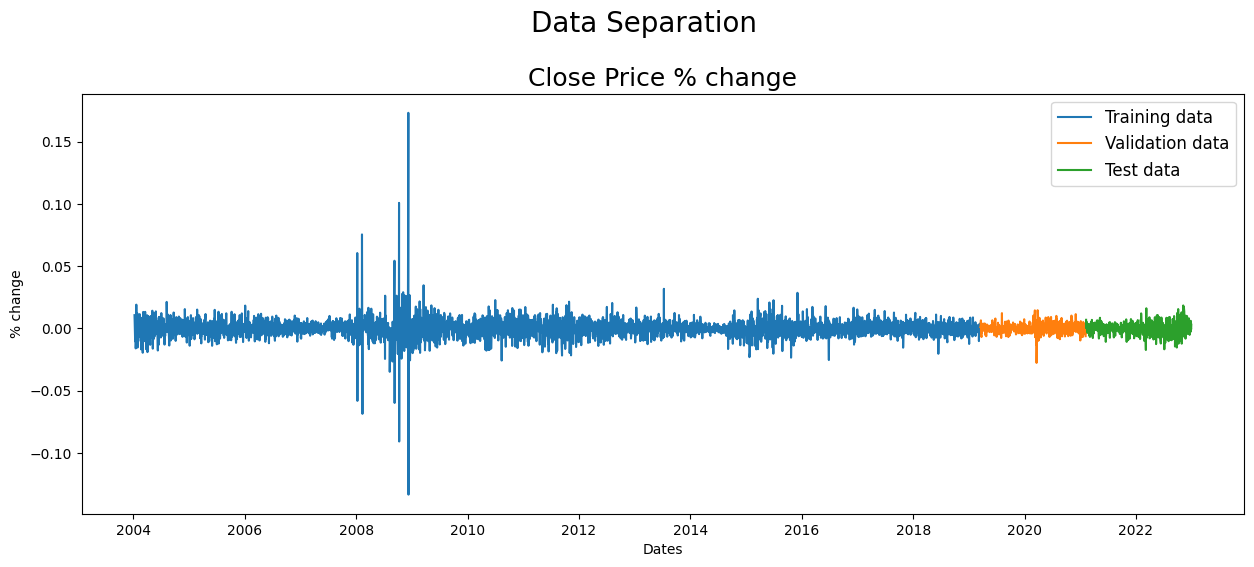

In [9]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(train_data_dates, df_train[target], label='Training data')
ax1.plot(val_data_dates, df_val[target], label='Validation data')
ax1.plot(test_data_dates, df_test[target], label='Test data')
ax1.set_xlabel('Dates')
ax1.set_ylabel('% change')
ax1.set_title("Close Price % change", fontsize=18)
ax1.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [10]:
target_id = list(df_train.columns).index(target)
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i])
    y_train.append(train_data[:, target_id][i])
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, target_id][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, target_id][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (3706, 256, 1) (3706,)
Validation set shape (239, 256, 1) (239,)
Testing set shape (239, 256, 1) (239,)


## TimeVector

In [11]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config
  

## Transformer

In [12]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k, 
                           input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', 
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k, 
                         input_shape=input_shape, 
                         kernel_initializer='glorot_uniform', 
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v, 
                           input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', 
                           bias_initializer='glorot_uniform')

    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out    

#############################################################################

class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  

        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
        self.linear = Dense(input_shape[0][-1], 
                            input_shape=input_shape, 
                            kernel_initializer='glorot_uniform', 
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.2, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer 

    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config          

## Model

In [17]:
def create_model(input_shape):
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, input_shape))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    #   x = Concatenate(axis=-1)([Dense(128)(in_seq), x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    # x = GlobalAveragePooling1D(data_format='channels_first')(x)
    # x = Dense(256, activation='relu')(x)
    x = Flatten()(x)    
    x = Dropout(0.02)(x)
    x = Dense(64, activation='linear')(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mape'])
    return model


model = create_model(df.shape[1])
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('FXTransformerUni{epoch:04}.keras', 
                                               monitor='val_loss', 
                                               save_best_only=True, verbose=1
                                             )

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


if True: 
    history = model.fit(X_train, y_train,
                        batch_size=batch_size, 
                        epochs=4,
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
    with open('historyUni.pkl', 'wb') as f:
        pickle.dump(history.history, f)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vector_3      │ (None, 256, 2)    │      1,024 │ input_layer_3[0]… │
│ (Time2Vector)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 3)    │          0 │ input_layer_3[0]… │
│ (Concatenate)       │                   │            │ time2_vector_3[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 3)    │     47,890 │ concatenate_3[0]… │
│ (TransformerEncode… │                   │            │ concatenate_3[0]… │
│                     │                   │            │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 3)    │     47,890 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ transformer_enco… │
│                     │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 3)    │     47,890 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ transformer_enco… │
│                     │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 768)       │          0 │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 768)       │          0 │ flatten_3[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_450 (Dense)   │ (None, 64)        │     49,216 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_451 (Dense)   │ (None, 1)         │         65 │ dense_450[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 193,975 (757.71 KB)

 Trainable params: 193,975 (757.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.3948 - mae: 1.3836 - mape: 3871.2412
Epoch 1: val_loss improved from inf to 0.64245, saving model to FXTransformerUni0001.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - loss: 3.3875 - mae: 1.3817 - mape: 3872.1750 - val_loss: 0.6424 - val_mae: 0.6181 - val_mape: 959.3671
Epoch 2/4
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.7401 - mae: 0.8401 - mape: 1949.8085
Epoch 2: val_loss improved from 0.64245 to 0.46283, saving model to FXTransformerUni0002.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - loss: 1.7367 - mae: 0.8396 - mape: 1950.5309 - val_loss: 0.4628 - val_mae: 0.5307 - val_mape: 332.3442
Epoch 3/4
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2060 - mae: 0.7384 - mape: 2217.1575
Epoch 3: val_loss improved from 0.46283 to 0.40604, saving model to FXTransformerUni0003.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - loss: 1.2059 - mae: 0.7382 - mape: 2215.2263 - val_loss: 0.4060 - val_mae: 0.4906 - val_ma

In [19]:
model_last = sorted([i for i in os.listdir() if 'keras' in i and 'FXTransformerUni' in i])[-1]

In [20]:
model = tf.keras.models.load_model(
    os.path.join(model_last),
    custom_objects={
        'Time2Vector': Time2Vector,
        'SingleAttention': SingleAttention,
        'MultiAttention': MultiAttention,
        'TransformerEncoder': TransformerEncoder
    }
)
with open('historyUni.pkl', 'rb') as f:
    history = pickle.load(f)

In [21]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

116/116 ━━━━━━━━━━━━━━━━━━━━ 111s 940ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 852ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 859ms/step
 
Evaluation metrics
Training Data - Loss: 1.0267, MAE: 0.6254, MAPE: 868.9789
Validation Data - Loss: 0.4060, MAE: 0.4906, MAPE: 265.5864
Test Data - Loss: 0.6763, MAE: 0.6340, MAPE: 154.0828


### Training error

In [22]:
def mde(y_true, y_pred):
    return 1 - np.equal(y_true[1:] - y_true[:-1] >= 0, y_pred[1:] - y_true[:-1] >= 0).mean()

In [23]:
y = sc_target.inverse_transform(y_train.reshape(-1, 1))
y_pred = sc_target.inverse_transform(train_pred)
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

mse: 6.287522410275415e-05
mae: 0.004893976729363203
mape: 16467.005859375
mde: 0.24399460188933875


### Validation Error

In [24]:
y = sc_target.inverse_transform(y_val.reshape(-1, 1))
y_pred = sc_target.inverse_transform(val_pred)
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

mse: 2.4865261366358027e-05
mae: 0.0038388301618397236
mape: 1858.0457763671875
mde: 0.273109243697479


### Test Error

In [25]:
y = sc_target.inverse_transform(y_test.reshape(-1, 1))
y_pred = sc_target.inverse_transform(test_pred)
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

mse: 4.141406316193752e-05
mae: 0.004961691331118345
mape: 154.14572143554688
mde: 0.2857142857142857


## Display Results

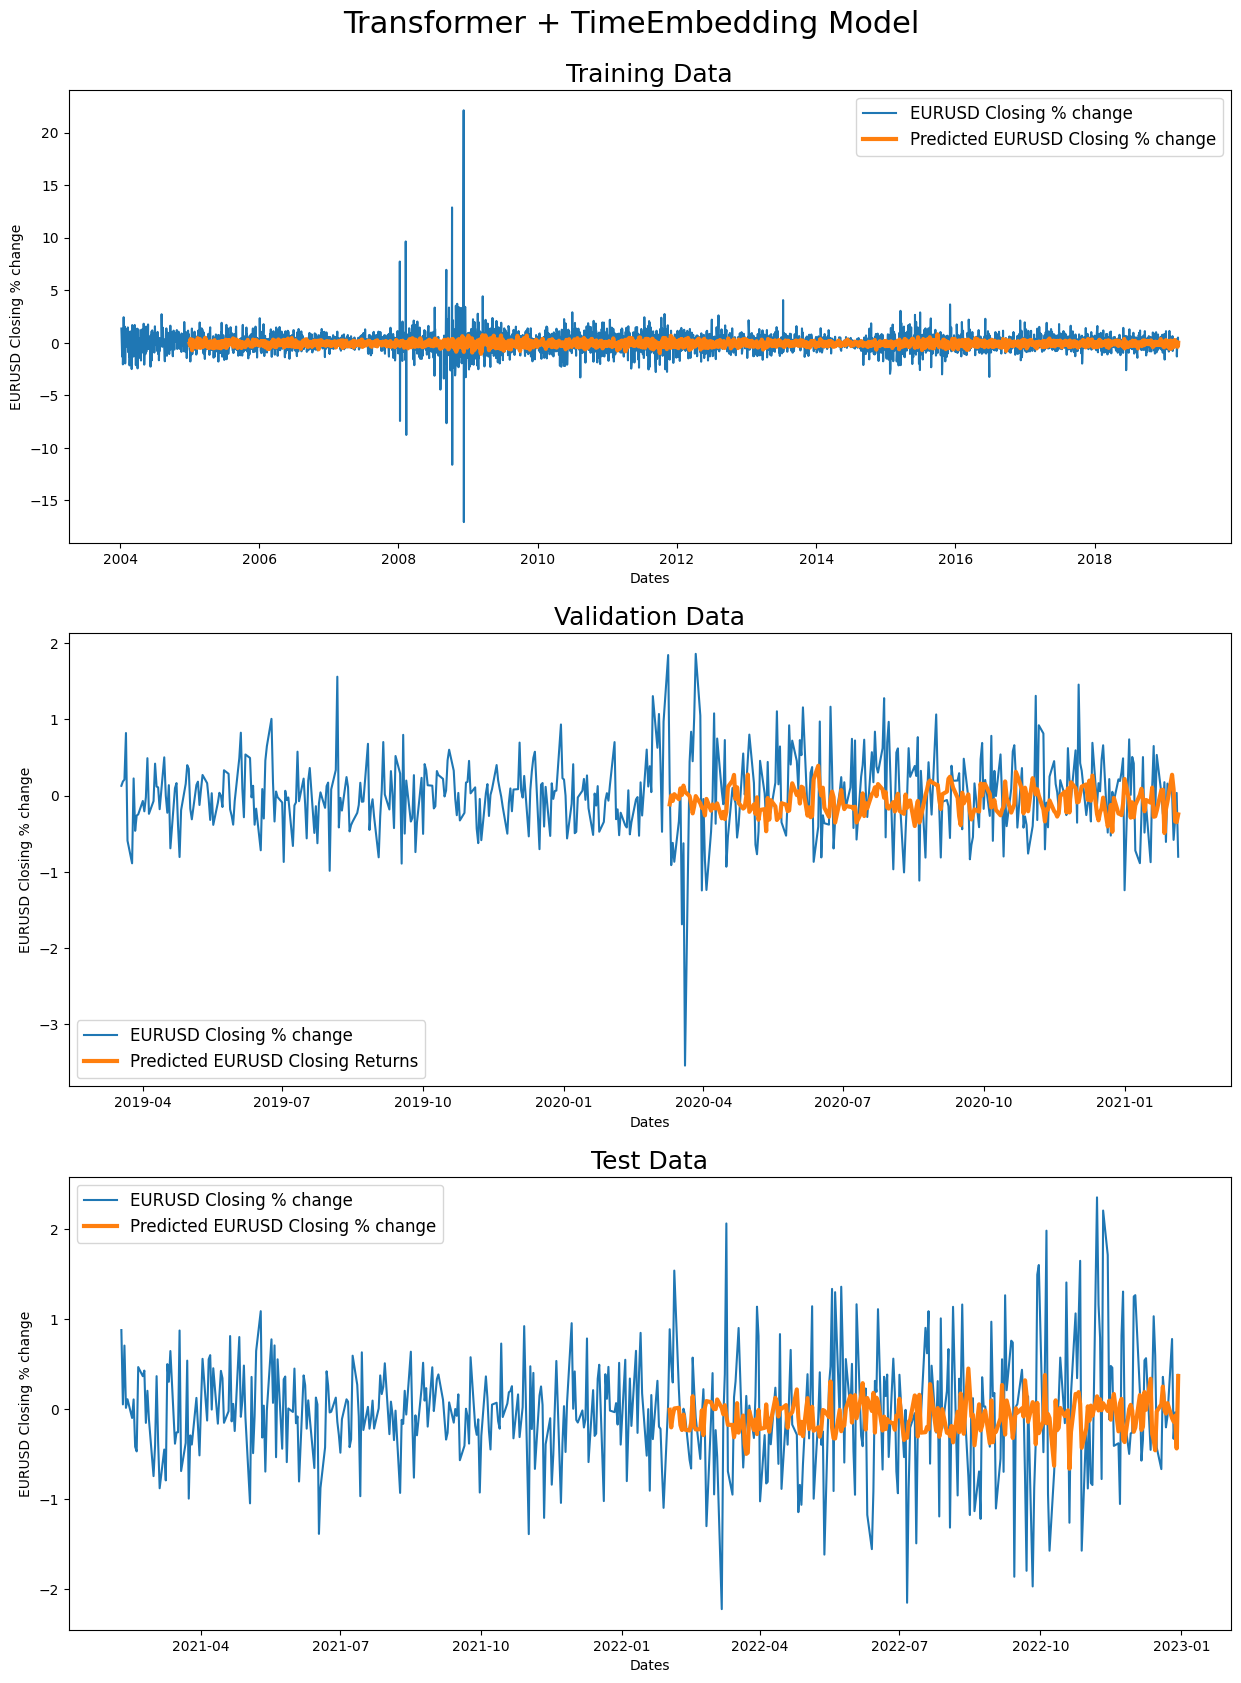

In [33]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data_dates, train_data[:, 0], label='EURUSD Closing % change')
ax11.plot(train_data_dates[seq_len:], train_pred, linewidth=3, label='Predicted EURUSD Closing % change')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Dates')
ax11.set_ylabel('EURUSD Closing % change')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data_dates, val_data[:, 0], label='EURUSD Closing % change')
ax21.plot(val_data_dates[seq_len:], val_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Dates')
ax21.set_ylabel('EURUSD Closing % change')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data_dates, test_data[:, 0], label='EURUSD Closing % change')
ax31.plot(test_data_dates[seq_len:], test_pred, linewidth=3, label='Predicted EURUSD Closing % change')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Dates')
ax31.set_ylabel('EURUSD Closing % change')
ax31.legend(loc="best", fontsize=12)

## Model metrics

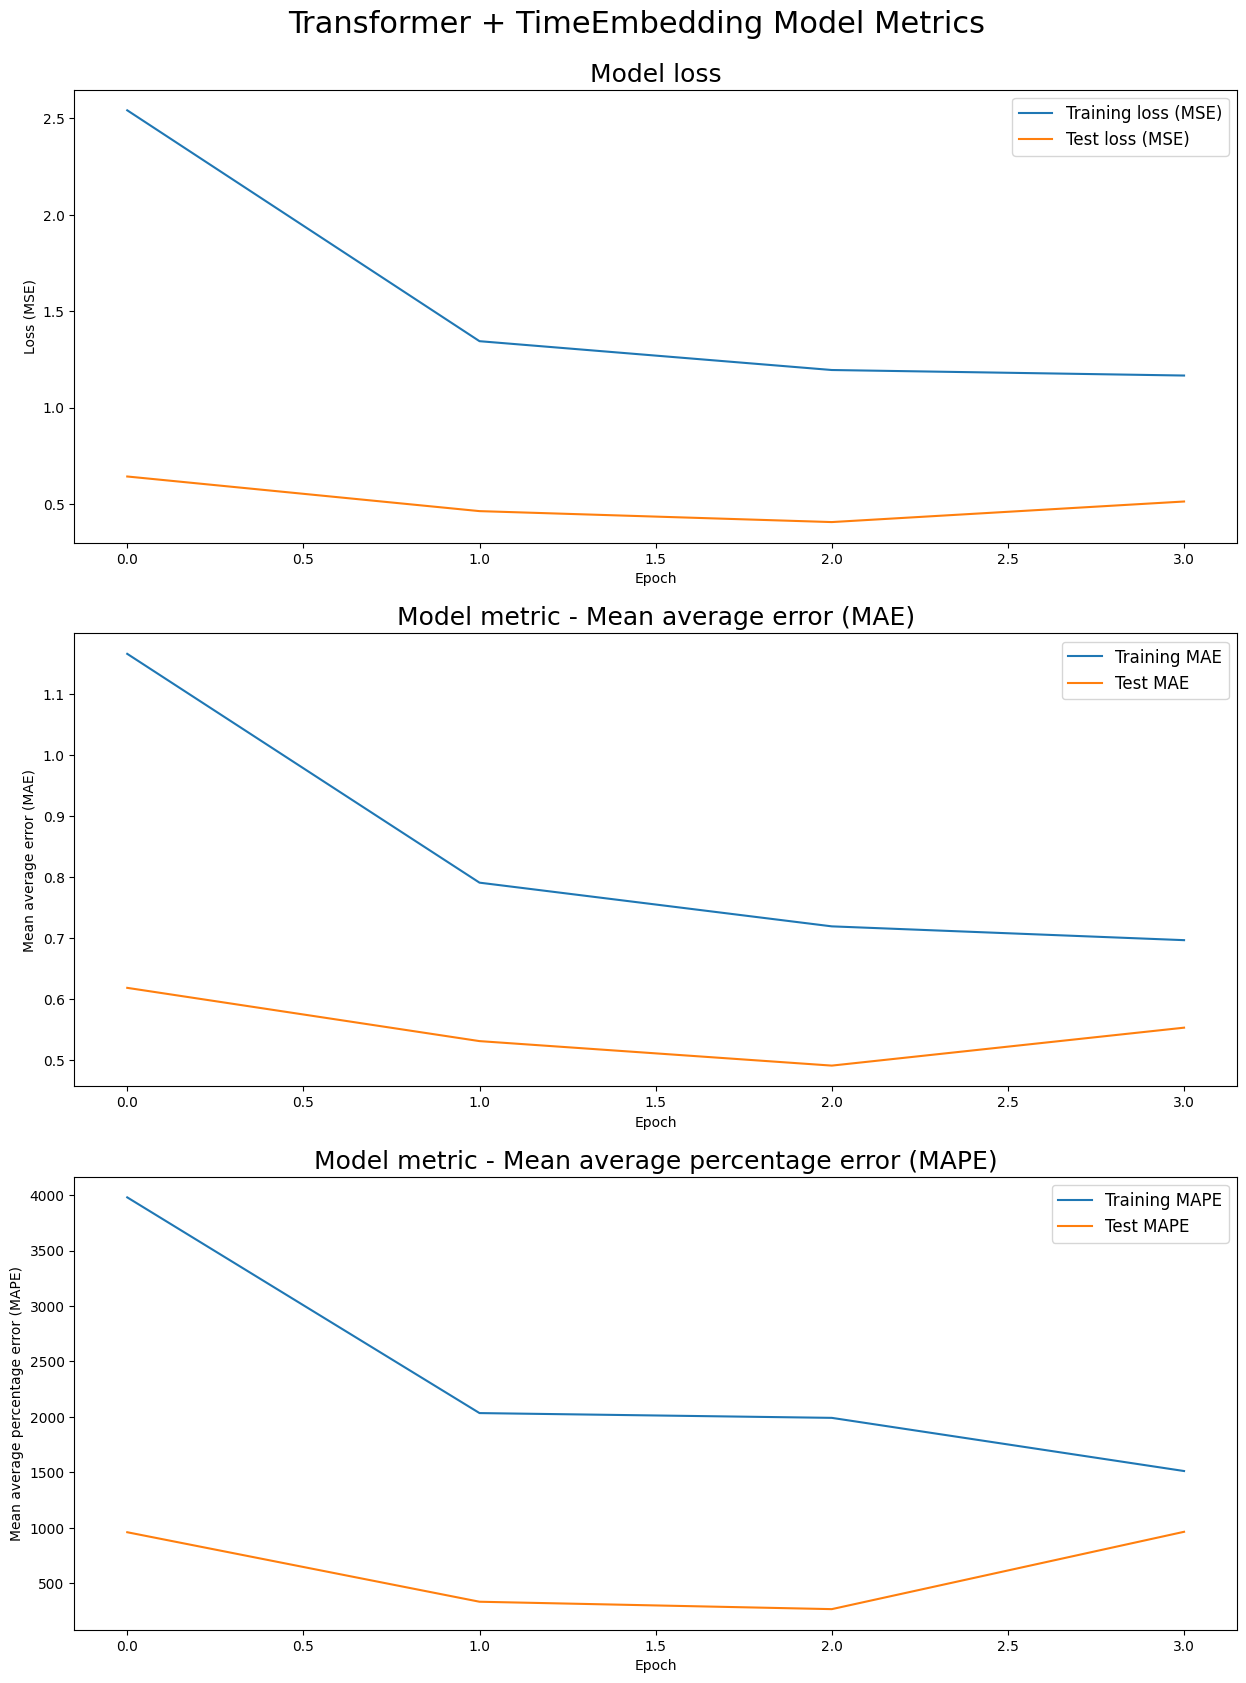

In [28]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history['loss'], label='Training loss (MSE)')
ax1.plot(history['val_loss'], label='Test loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history['mae'], label='Training MAE')
ax2.plot(history['val_mae'], label='Test MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history['mape'], label='Training MAPE')
ax3.plot(history['val_mape'], label='Test MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

In [32]:
tf.keras.utils.plot_model(
    model,
    to_file="FXTransformerUni.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [31]:
import matplotlib.image as mpimg


# Carga y muestra la imagen
img = mpimg.imread('FXTransformerUni.png')
imgplot = plt.imshow(img)
plt.axis('off')  # Oculta los ejes
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'FXTransformerUni.png'